## Validate and calibrate the CovBox data

In [1]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import glob
import fitsio
import random
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter, NullFormatter
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 12
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from mockfactory import utils, DistanceToRedshift, Catalog, RandomBoxCatalog
from cosmoprimo.fiducial import DESI, AbacusSummit
from pycorr import TwoPointCorrelationFunction
from pycorr import project_to_multipoles, project_to_wp
from pypower import CatalogFFTPower, PowerSpectrumMultipoles, setup_logging
from pyrecon import MultiGridReconstruction, IterativeFFTReconstruction, IterativeFFTParticleReconstruction, utils, setup_logging

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
sys.path.append('/global/homes/s/shengyu/project_rc/main/Y3/')
from helper import REDSHIFT_VSMEAR, REDSHIFT_CUBICBOX, Y3_EFFECTIVE_VOLUME, EDGES, RSF_COV_ERROR, RSF_EZMOCKS_ERROR,  GET_RECON_BIAS
from helper import REDSHIFT_LSS_VSMEAR, REDSHIFT_LSS_CUBICBOX, REDSHIFT_LSS_EZMOCKS, PLANCK_COSMOLOGY
from fit_cubic_tools import load_bins, load_rescalc_cov, load_mock_cov, get_observable_likelihood
%load_ext autoreload
%autoreload 2

Z_VSMEAR = REDSHIFT_LSS_VSMEAR
# Z_CUBIC = REDSHIFT_LSS_CUBICBOX
Z_CUBIC = REDSHIFT_LSS_EZMOCKS
base_dir = '/pscratch/sd/s/shengyu/results/cubic_test'

In [3]:
base_dir = "/global/cfs/cdirs/desi/users/arocher/Y3/AbacusBox/kibo_v1/ELG/cosmo_0/z0.950/AbacusSummit_base_c000_ph000"
mock_fn = base_dir+'catalog_ELG_z0.950_mHMQ+cf+mnfw_kibo-v1_v0.1_PIP.fits'

In [4]:
# Check the data of CovBox
tracers = ['LRG', 'ELG', 'QSO']
for tracer in tracers:
    z_cubic = REDSHIFT_CUBICBOX[tracer][0]
    mock_id04 =  random.randint(3000, 4500)
    dir = f'/global/cfs/cdirs/desi/cosmosim/AbacusHOD_mocks/v1/CovBox/{tracer}/z{z_cubic:.3f}'
    if tracer == 'LRG':
        catalog_fn = dir + f'/catalog_rsd_xi2d_{tracer.lower()}_main_z{z_cubic:.1f}_velbias_mockcov_ph{mock_id04}.fits'
    elif tracer == 'ELG':
        catalog_fn = dir + f'/catalog_rsd_xi2d_{tracer.lower()}_z{z_cubic:.1f}_velbias_B_mockcov_ph{mock_id04}.fits'
    elif tracer == 'QSO':
        catalog_fn = dir + f'/catalog_rsd_xi2d_{tracer.lower()}_z{z_cubic:.1f}_velbias_B_mockcov_zerr_skip5_ph{mock_id04}.fits'
    if not os.path.isfile(catalog_fn):
        print(f"File not found: {catalog_fn}. Skipping mock_id={mock_id04}",flush=True)
    catalog = Catalog.read(catalog_fn, filetype='fits')
    for i,(zmin, zmax) in enumerate(REDSHIFT_LSS_VSMEAR[tracer]):
        print(tracer, z_cubic, (zmin, zmax), len(catalog))
        # nb = NUMBER_Y3_REDSHIFT[tracer]
        y3_veff = Y3_EFFECTIVE_VOLUME[tracer][i]
        rsf = 2./y3_veff
        print(np.sqrt(rsf))

LRG 0.5 (0.4, 0.6) 62989
0.6388765649999398
LRG 0.5 (0.6, 0.8) 62989
0.512989176042577
LRG 0.5 (0.8, 1.1) 62989
0.4517539514526256
File not found: /global/cfs/cdirs/desi/cosmosim/AbacusHOD_mocks/v1/CovBox/ELG/z0.800/catalog_rsd_xi2d_elg_z0.8_velbias_B_mockcov_ph3475.fits. Skipping mock_id=3475


OSError: FITSIO status = 104: could not open the named file
failed to find or open the following file: (ffopen)
/global/cfs/cdirs/desi/cosmosim/AbacusHOD_mocks/v1/CovBox/ELG/z0.800/catalog_rsd
_xi2d_elg_z0.8_velbias_B_mockcov_ph3475.fits


QSO 1.1 (0.8, 2.1) False
2000


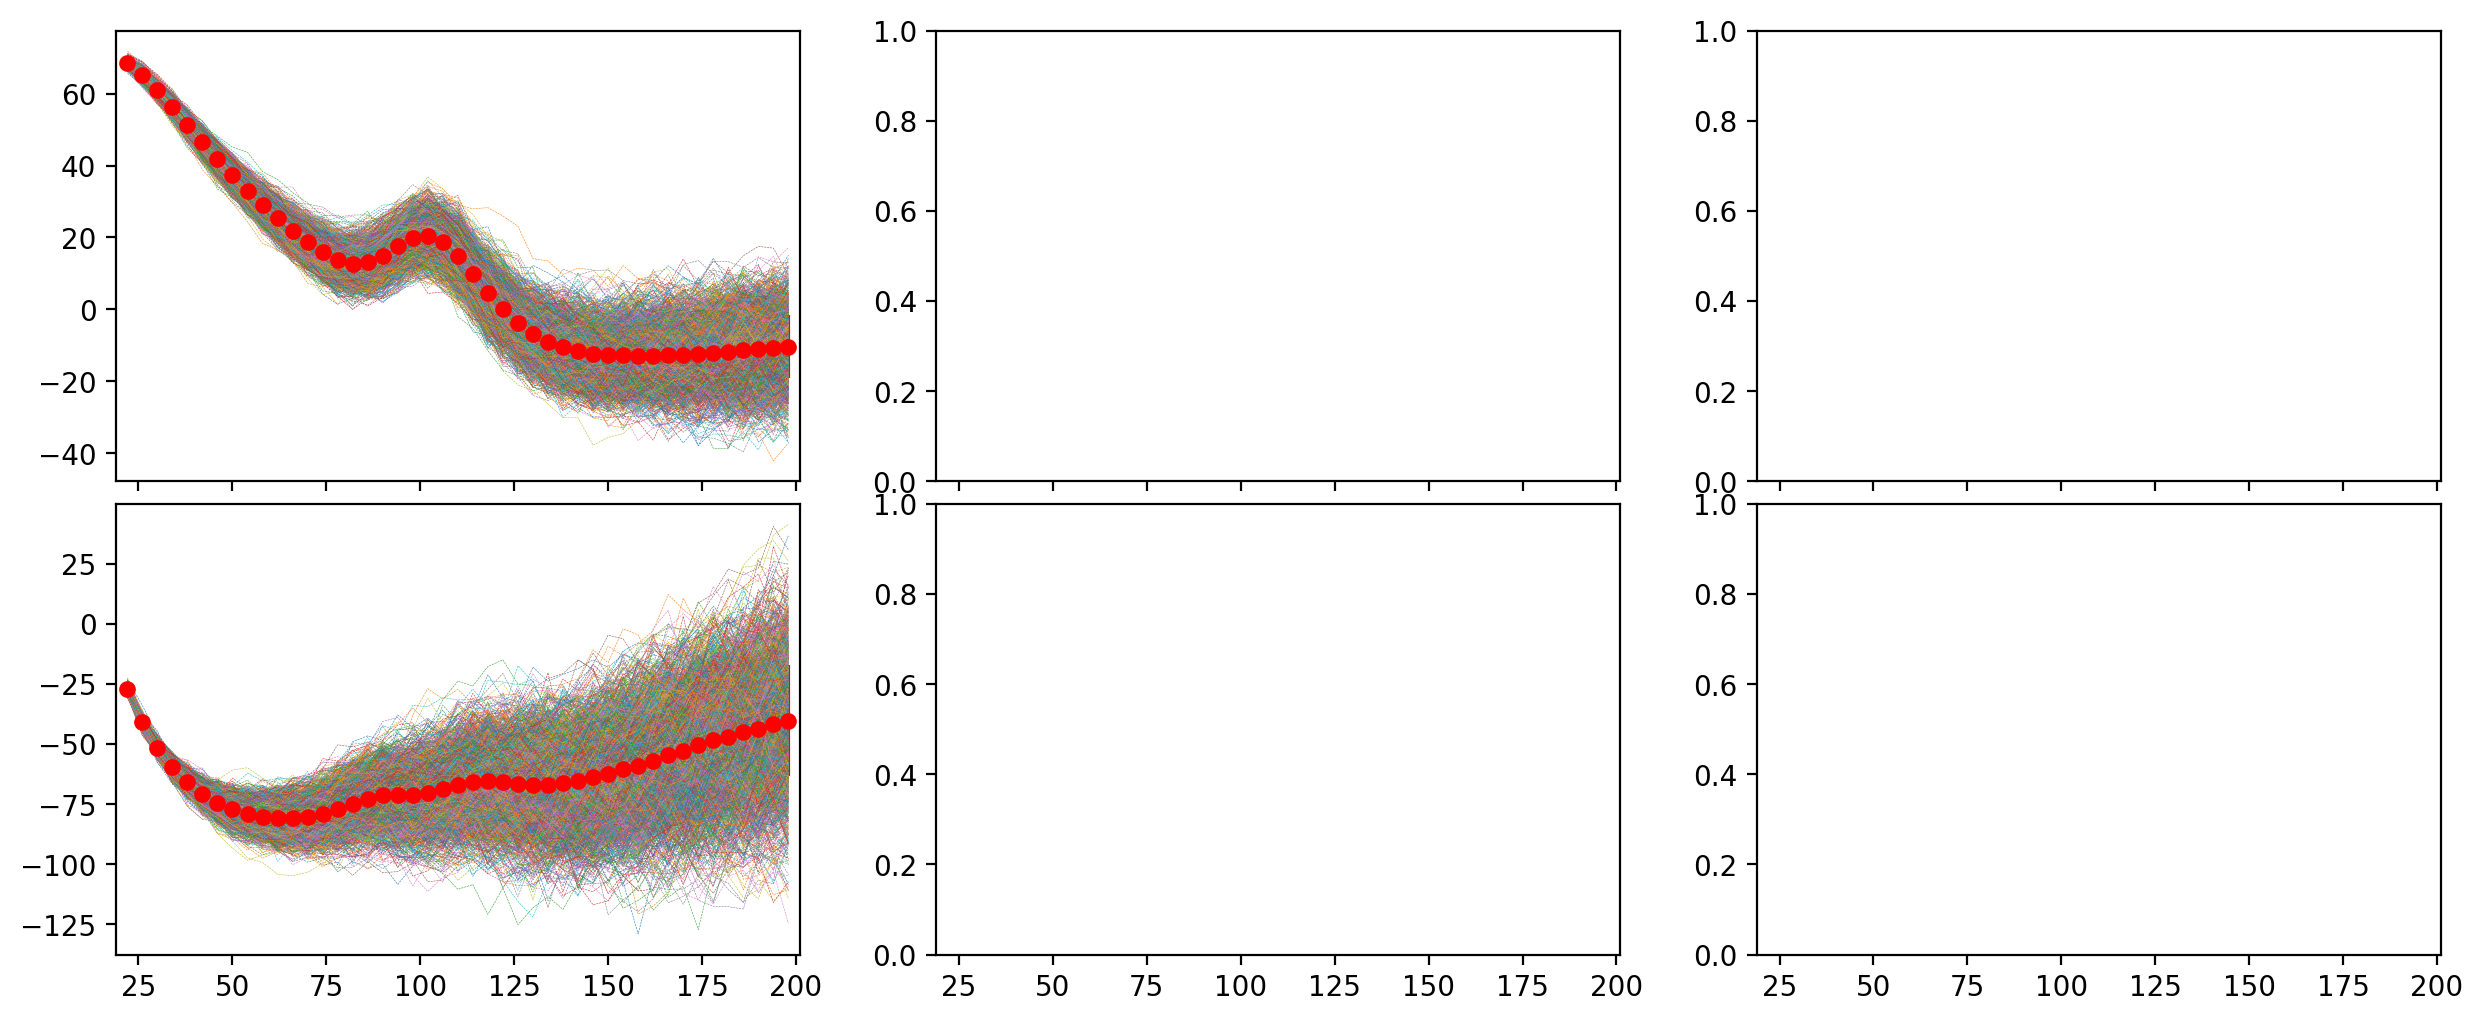

In [84]:
# Plot the CovBox data for error bar reference and covariance maybe
setup_logging(level='warning')
%matplotlib inline
corr = 'xi'
boxsize = 1500.
(rmin, rmax, rbin, lenr) = load_bins('xi', 'test')

tracer = 'QSO'
recon = False
# tracers = ['BGS','LRG', 'ELG', 'QSO']
fig, ax = plt.subplots(2, 3, figsize = (15,6), sharex=True, gridspec_kw={'height_ratios': [1,1]})
fig.subplots_adjust(hspace=0.05)
# for i,tracer in enumerate(tracers):
# Z_RANGE = Z_VSMEAR[tracer]
Z_RANGE = Z_VSMEAR[tracer]
# zz = [0,1]
# Z_RANGE = np.array(Z_VSMEAR[tracer])[zz]
for i,(zmin, zmax) in enumerate(Z_RANGE):
    # z_cubic = Z_CUBIC[tracer][zz[i]]
    z_cubic = Z_CUBIC[tracer][i]
    xi_ = []
    count = 0
    # mockids = np.arange(3000,4500)
    mockids = np.arange(1,2001)
    # for z_cubic, (zmin, zmax) in zip(Z_CUBIC[tracer], Z_VSMEAR[tracer]):
    print(tracer, z_cubic, (zmin, zmax), recon)
    for mock_id in mockids:
        mock_id04 =  f"{mock_id:04}"
        # base_dir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CovBox'
        base_dir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/{tracer}/z{z_cubic:.3f}/{corr}'
        # data_fn = base_dir+ f'/{tracer}/z{z_cubic:.3f}/xi/xipoles_{tracer}_z{z_cubic:.1f}_ph{mock_id04}.npy'
        data_fn = base_dir+ f'/xipoles_{tracer}_z{zmin:.1f}-{zmax:.1f}_{mock_id04}.npy'
        if recon == True:
            data_fn = base_dir+ f'/recon/xipoles_{tracer}_z{z_cubic:.1f}_ph{mock_id04}.npy'
        # print(data_fn)
        if not os.path.isfile(data_fn):
            # print(f"File not found: {data_fn}. Skipping mock_id={mock_id04}")
            continue
        result = TwoPointCorrelationFunction.load(data_fn)
        result = result[::rbin,::]
        result.select((rmin, rmax))
        s, xi = project_to_multipoles(result, ells=[0,2])
        # if max(abs(s**2*xi[0])) > 500:
        # if max(abs(s**2*xi[1])) > 200:
        # if max((s**2*xi[1])) > 200:
        # if min((s[:3]**2*xi[0][:3])) < 80:
        if False:
            # print(tracer, z_cubic, mock_id04)
            print(data_fn)
        else:
            count += 1
            xi_.append(xi)
            for ell in range(2):
                ax[ell][i].plot(s, s**2*xi[ell], lw = 0.2, ls = '--')
    plt.xlim([19,201])
    xi_ =  [np.mean(xi_, axis=0), np.std(xi_, axis=0)]
    # error_data = np.column_stack((xi_[1][0], xi_[1][1]))
    # np.savetxt(f"/global/homes/s/shengyu/project_rc/main/Y3/data/errorbar/error_covbox_xi_{tracer}_z{z_cubic:.1f}.txt", error_data, header="xi0_error  xi2_error", fmt="%.6e")
    # continue
    for ell in range(2):
        ax[ell][i].errorbar(s, s**2*xi_[0][ell], yerr=s**2*xi_[1][ell], color = 'red', fmt = 'o', markersize = 5)
    # if corr == 'xi':
    #     plt.ylim([ -2, 6])
    print(count)

In [14]:
zz = [1,2]

Z_RANGE = np.array(Z_VSMEAR[tracer])[zz]
print(Z_RANGE)

[[0.6 0.8]
 [0.8 1.1]]


ELG 0.95 (0.8, 1.1) False
2000
ELG 1.1 (1.1, 1.6) False
2000


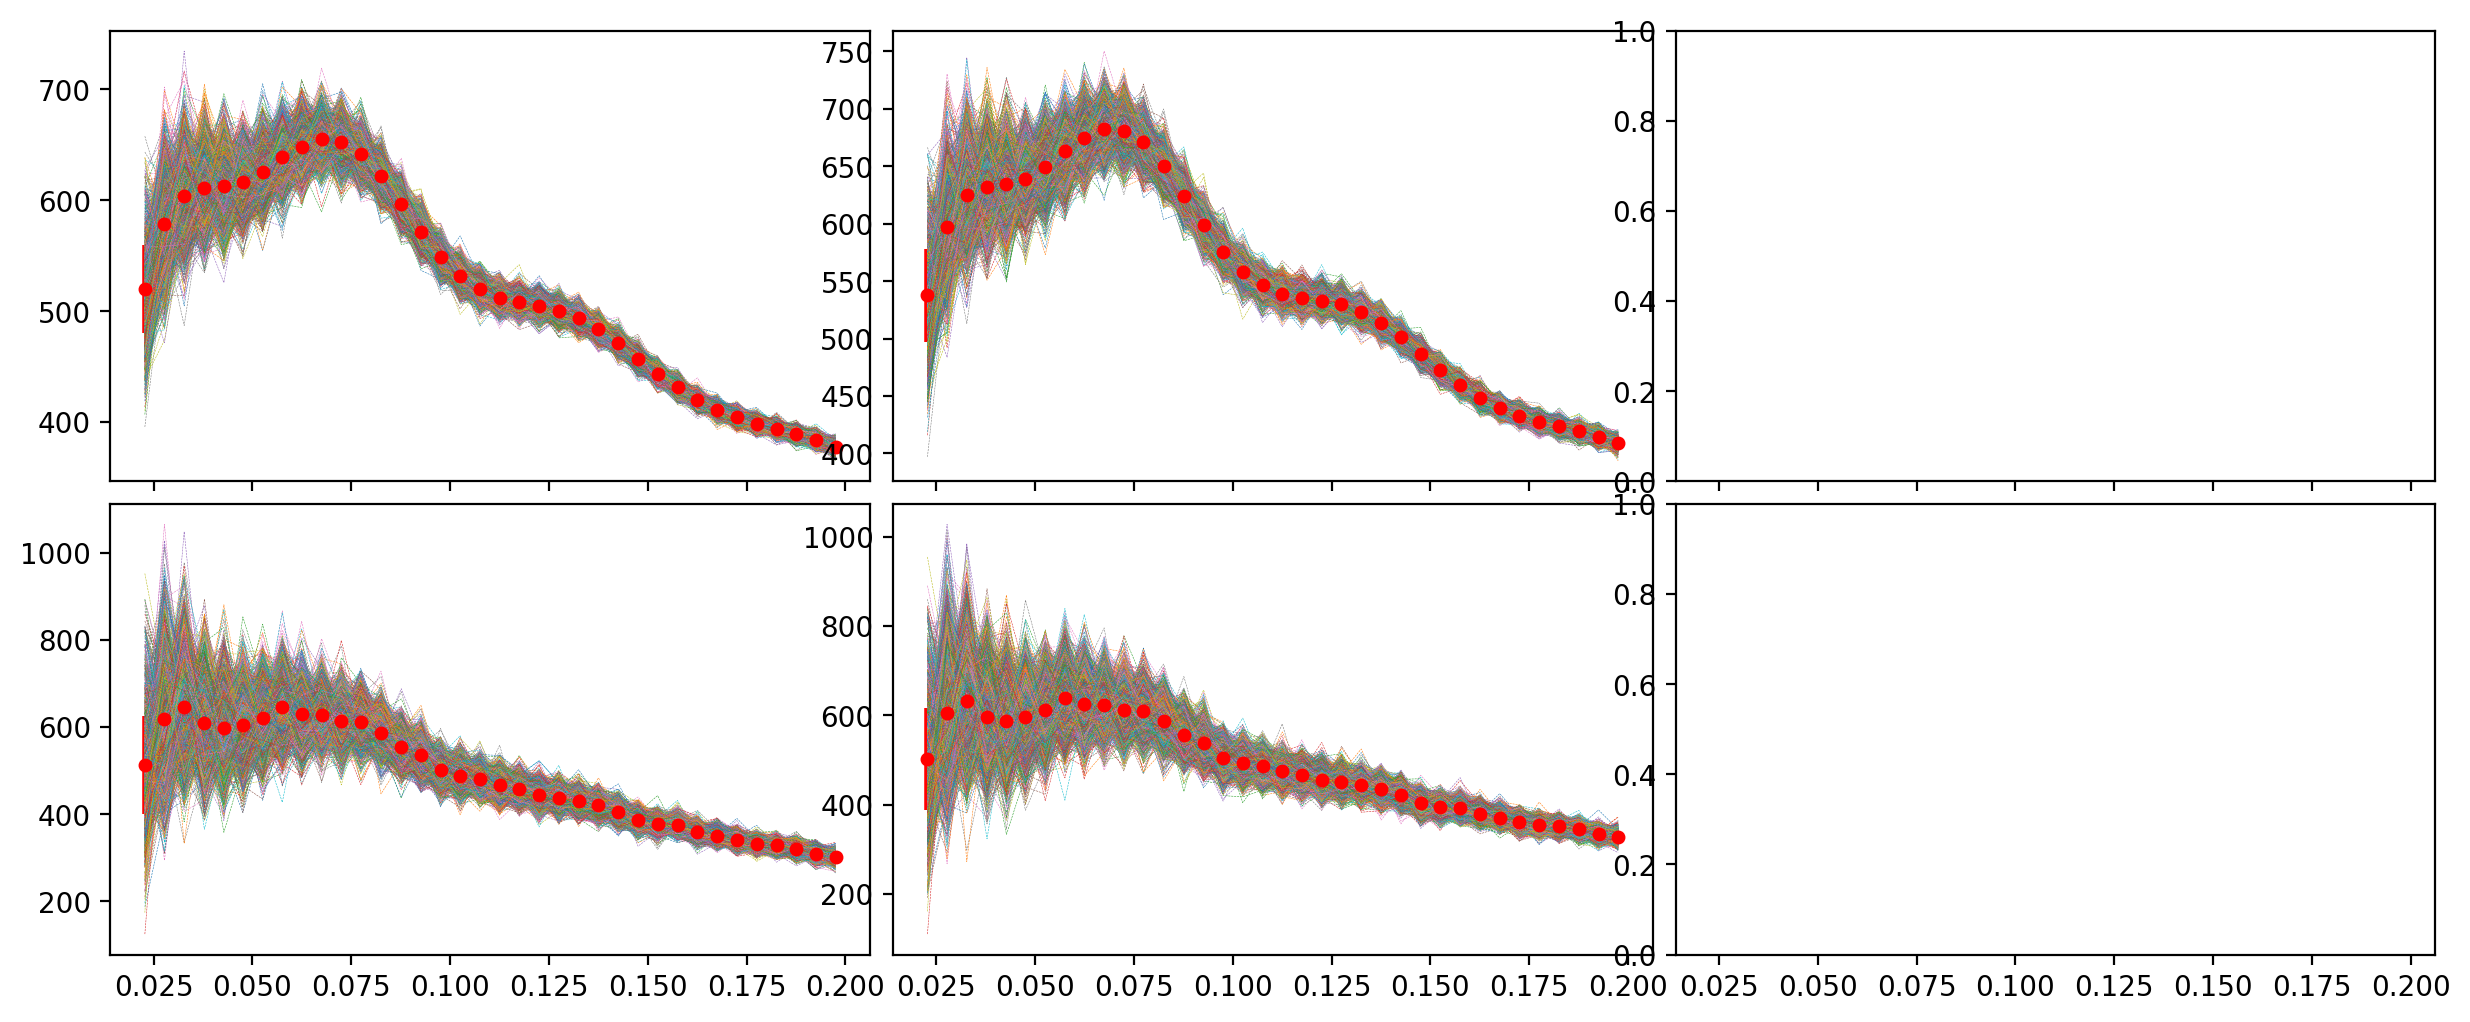

In [3]:
# Plot the CovBox data for error bar reference and covariance maybe
setup_logging(level='warning')
%matplotlib inline
corr = 'pk'
boxsize = 1500.
(kmin, kmax, kbin, lenk) = load_bins('pk', 'y3_sys')
# tracers = ['LRG', 'ELG', 'QSO']
tracer = 'ELG'
recon = False

fig, ax = plt.subplots(2, 3, figsize = (15,6), sharex=True, gridspec_kw={'height_ratios': [1,1]})
fig.subplots_adjust(wspace=0.03, hspace=0.05)
# zz = [0]
# Z_RANGE = np.array(Z_VSMEAR[tracer])[zz]
Z_RANGE = Z_VSMEAR[tracer]
for i,(zmin, zmax) in enumerate(Z_RANGE):
    z_cubic = Z_CUBIC[tracer][i]
    pk_ = []
    count = 0
    # mockids = np.arange(3000,4500)
    mockids = np.arange(1,2001)
    # for z_cubic, (zmin, zmax) in zip(Z_CUBIC[tracer], Z_VSMEAR[tracer]):
    print(tracer, z_cubic, (zmin, zmax), recon)
    for mock_id in mockids:
        mock_id04 =  f"{mock_id:04}"
        # base_dir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CovBox'
        base_dir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/{tracer}/z{z_cubic:.3f}/{corr}'
        # data_fn = base_dir+ f'/{tracer}/z{z_cubic:.3f}/pk/pkpoles_{tracer}_z{z_cubic:.1f}_ph{mock_id04}.npy'
        data_fn = base_dir+ f'/pkpoles_{tracer}_z{zmin:.1f}-{zmax:.1f}_{mock_id04}.npy'
        if not os.path.isfile(data_fn):
            # print(f"File not found: {data_fn}. Skipping mock_id={mock_id04}")
            continue
        result = PowerSpectrumMultipoles.load(data_fn)
        result = result.select((kmin,kmax,kbin))
        pk = np.real(result.get_power())
        k = result.kavg
        # if max((k[20:40]*pk[0][20:40])) > 2000:
        # if max(abs(k*pk[1])) > 6000:
        if False:
        #     print(tracer, z_cubic, mock_id04)
            print(data_fn)
        else:
            count += 1
            pk_.append(pk)
            for ell in range(2):
                ax[ell][i].plot(k, k*pk[ell], lw = 0.2, ls = '--')
    # plt.xlim([20,200])
    pk_ =  [np.mean(pk_, axis=0), np.std(pk_, axis=0)]
    error_data = np.column_stack((pk_[1][0], pk_[1][1]))
    for ell in range(2):
        ax[ell][i].errorbar(k, k*pk_[0][ell], yerr=k*pk_[1][ell], lw = 2, color = 'red', fmt = 'o', markersize = 4)
    # if corr == 'xi':
    #     plt.ylim([ -2, 6])
    print(count)

In [9]:
setup_logging(level='warning')
corr = 'xi'
tracer = 'QSO'
z_cubic = REDSHIFT_CUBICBOX[tracer][0]
(zmin, zmax) = REDSHIFT_VSMEAR[tracer][0]
boxsize = 500.
data_args = {"tracer": tracer, "z_eff": z_cubic, "zmin": zmin, "zmax": zmax, "recon": False, "grid_cosmo": "000"}
cov_rescalC = load_rescalc_cov(data_args, bins_type = None)

(rmin, rmax, rbin, lenr) = load_bins('xi', 'test')
xi_ = []
mockids = np.arange(3000,4500)
for mock_id in mockids:
    mock_id04 =  f"{mock_id:04}"
    base_dir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CovBox'
    data_fn = base_dir+ f'/{tracer}/z{z_cubic:.3f}/xi/recon/xipoles_{tracer}_z{z_cubic:.1f}_ph{mock_id04}.npy'
    if not os.path.isfile(data_fn):
        continue
    result = TwoPointCorrelationFunction.load(data_fn)
    result = result[::rbin,::]
    result.select((rmin, rmax))
    s, xi = project_to_multipoles(result, ells=[0,2])
    xi_.append(xi)
xi_ = np.array(xi_)  # Shape (N_mocks, N_bins)
xi_ = xi_.reshape(len(xi_), -1)
rsf = RSF_COV_ERROR[tracer]
cov = np.cov(xi_, rowvar=False, ddof=1)

[000005.11]  03-01 01:54  TwoPointEstimator            INFO     Loading /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CovBox/QSO/z1.100/xi/recon/xipoles_QSO_z1.1_ph3000.npy.


[000005.21]  03-01 01:54  numexpr.utils                INFO     Note: detected 256 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[000005.21]  03-01 01:54  numexpr.utils                INFO     Note: NumExpr detected 256 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
[000005.21]  03-01 01:54  numexpr.utils                INFO     NumExpr defaulting to 16 threads.
[000005.38]  03-01 01:54  TwoPointEstimator            INFO     Loading /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CovBox/QSO/z1.100/xi/recon/xipoles_QSO_z1.1_ph3001.npy.
[000005.40]  03-01 01:54  TwoPointEstimator            INFO     Loading /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CovBox/QSO/z1.100/xi/recon/xipoles_QSO_z1.1_ph3002.npy.
[000005.42]  03-01 01:54  TwoPointEstimator            INFO     Loading /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CovBox/QSO/z1.100/xi/re

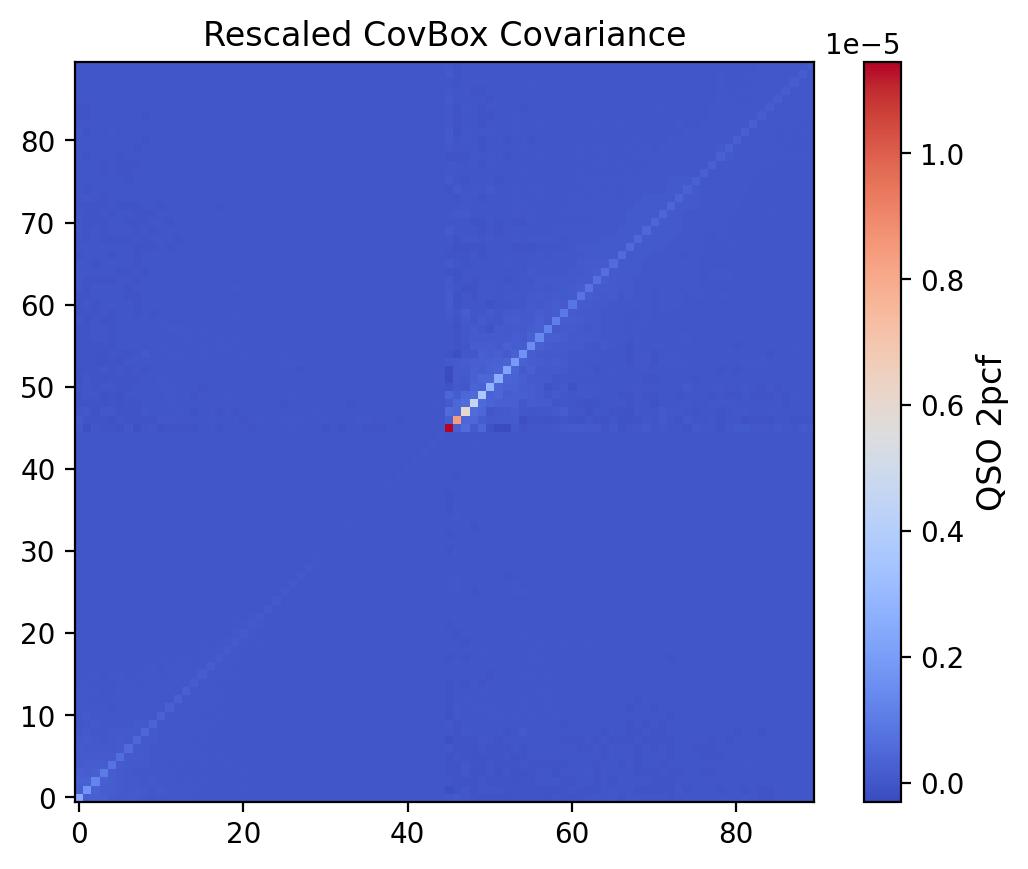

In [10]:
# Compute global min and max across both covariance matrices
# vmin = cov_rescalC[:90].min()
# vmax = cov_rescalC[:90].max()
# rsf = RSF_COV_ERROR[tracer]

# plt.imshow(cov_rescalC[:90, :90], cmap='coolwarm', origin='lower', vmin=vmin, vmax=vmax)
# plt.colorbar(label=f'{tracer} 2pcf')
# plt.title("RescalC Covariance")
# plt.tight_layout()
plt.show()
plt.imshow(cov*rsf**2, cmap='coolwarm', origin='lower')
plt.colorbar(label=f'{tracer} 2pcf')
plt.title("Rescaled CovBox Covariance")
plt.show()

(72, 72)


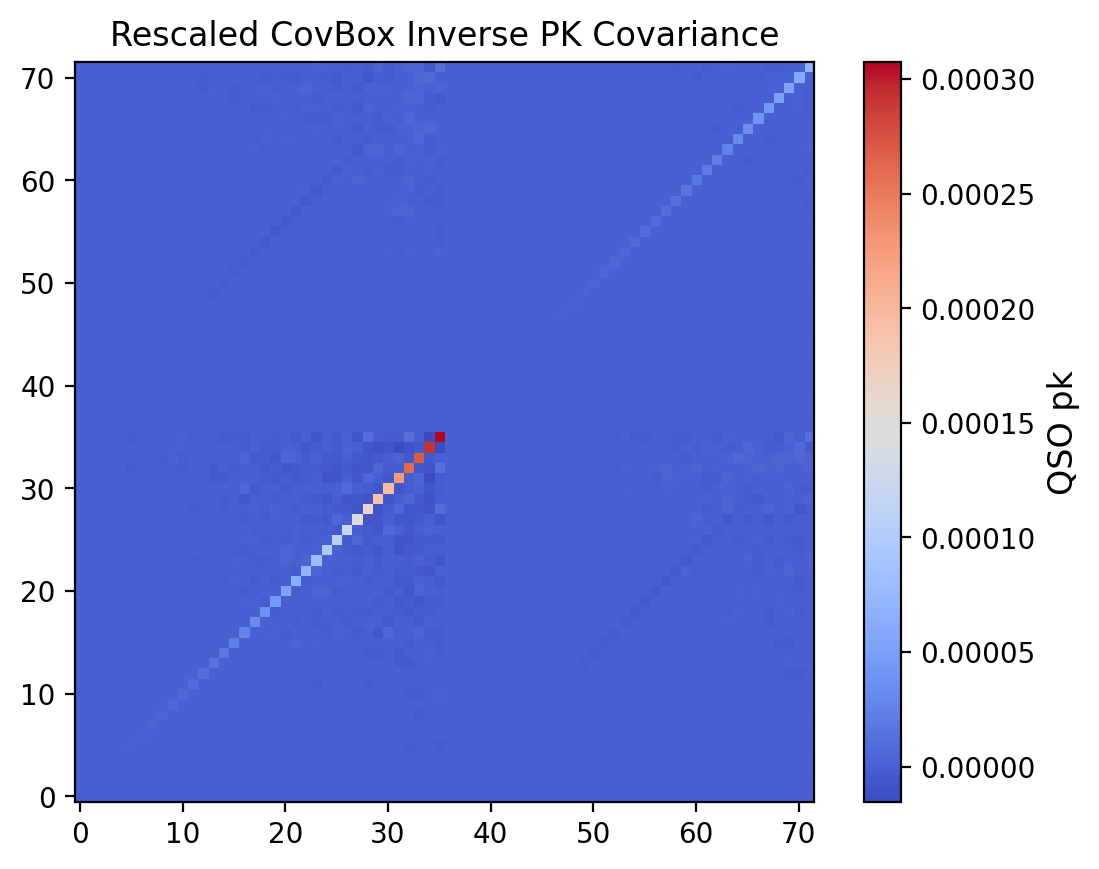

In [11]:
tracer = 'QSO'
corr_type = 'pk'
recon  = False
sys_model = 'standard'

z = 0
(zmin, zmax) = Z_VSMEAR[tracer][z]
z_eff = Z_CUBIC[tracer][z]
data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, 
             'corr_type':corr_type, "recon": recon, 
             "sys_model": sys_model, "grid_cosmo": "000"}
cov = load_mock_cov(data_args,  cov_type='EZmocks', corr_type = corr_type, bins_type = 'y3_sys', rsf = False)
# cov = load_covbox_cov(data_args, corr_type = corr_type, bins_type = 'y3_sys')
print(cov.shape)

if corr_type == 'pk':
    icov = np.linalg.inv(cov)
    vmin = icov.min()
    vmax = icov.max()
    plt.imshow(icov, cmap='coolwarm', origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar(label=f'{tracer} pk')
    plt.title("Rescaled CovBox Inverse PK Covariance")
    plt.show()
elif corr_type == 'xi':
    vmin = cov.min()
    vmax = cov.max()
    plt.imshow(cov, cmap='coolwarm', origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar(label=f'{tracer} xi')
    plt.title("Rescaled CovBox XI Covariance")
    plt.show()

# cov = load_covbox_cov(data_args, corr_type = 'pk', bins_type = 'y3_fs')
# print(cov.shape)
# icov = np.linalg.inv(cov)
# vmin = icov.min()
# vmax = icov.max()
# plt.imshow(icov, cmap='coolwarm', origin='lower', vmin=vmin, vmax=vmax)
# plt.colorbar(label=f'{tracer} pk')
# plt.title("Rescaled CovBox Inverse Covariance")
# plt.show()

In [4]:
from fit_cubic_tools import load_bins, load_rescalc_cov, load_mock_cov
tracers = ['LRG', 'ELG', 'QSO']
recon = False
corr_type = 'pk'
bins_type = 'y3_sys'
rsf = True

for tracer in tracers:
    for z_eff, (zmin, zmax) in zip(REDSHIFT_LSS_EZMOCKS[tracer], REDSHIFT_LSS_VSMEAR[tracer]):
        data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "recon": False, "grid_cosmo": "000"}
        if corr_type == 'xi':
            (rmin, rmax, rbin, lenr) = load_bins(corr_type, bins_type)
            base_dir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/covariance/{corr_type}'
            cov_fn = base_dir+f'/cov_EZmocks_1.5Gpc_{corr_type}02_{tracer}_z{zmin}-{zmax}_s{rmin}-{rmax}.txt'
            if rsf == True:
                cov_fn = base_dir+f'/cov_EZmocks_1.5Gpc_{corr_type}02_{tracer}_z{zmin}-{zmax}_s{rmin}-{rmax}_rsfDR2.txt'
        if corr_type == 'pk':
            (kmin, kmax, kbin, lenk) = load_bins(corr_type, bins_type)
            base_dir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/covariance/{corr_type}'
            cov_fn = base_dir+f'/cov_EZmocks_1.5Gpc_{corr_type}02_{tracer}_z{zmin}-{zmax}_k{kmin}-{kmax}.txt'
            if rsf == True:
                cov_fn = base_dir+f'/cov_EZmocks_1.5Gpc_{corr_type}02_{tracer}_z{zmin}-{zmax}_k{kmin}-{kmax}_rsfDR2.txt'   
        if not os.path.isfile(cov_fn):
            np.savetxt(cov_fn, load_mock_cov(data_args, 'EZmocks', corr_type, bins_type, rsf = rsf))

CovRsf: 0.2105
CovRsf: 0.1357
CovRsf: 0.1053
CovRsf: 0.1778
CovRsf: 0.1243
CovRsf: 0.382


In [6]:
np.sqrt(0.2105)

0.45880278987817846

In [ ]:
cov = np.loadtxt('/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/covariance/xi/cov_EZmocks_1.5Gpc_xi02_ELG_z0.8-1.1_s60_150.txt')
print(cov.shape)

(46, 46)


In [ ]:
tracer = 'LRG'
recon = False

for z_eff, (zmin, zmax) in zip(REDSHIFT_LSS_EZMOCKS[tracer], REDSHIFT_LSS_VSMEAR[tracer]):
    data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "recon": recon, "grid_cosmo": "000"}
    corr_type = 'pk'
    bins_type = 'y3_fs'
    (rmin, rmax, rbin, lenr) = load_bins(corr_type, bins_type)
    cov_fn = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/covariance/{corr_type}'+f'/cov_EZmocks_1.5Gpc_{corr_type}02_{tracer}_z{zmin}-{zmax}_s{rmin}_{rmax}.txt'
    # cov_fn = f'covariance_EZmocks_xi02_recon_{tracer}_z{zmin}-{zmax}_s{rmin}_{rmax}.txt'
    # cov_fn = f'covariance_EZmocks_pk02_{tracer}_z{zmin}-{zmax}_k{kmin}_{kmax}.txt'
    # cov_fn = f'covariance_RascalC_xi02_{tracer}_z{zmin}-{zmax}_s{rmin}_{rmax}.txt'
    # load_ez_cov(data_args, corr_type = corr_type, bins_type = bins_type)
    if not os.path.isfile(cov_fn):
        np.savetxt(cov_fn, load_mock_cov(data_args, corr_type = corr_type, bins_type = bins_type))
    # /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/LRG/z0.500/xi/xipoles_LRG_z0.4-0.6_0000.npy.npy

In [47]:
from fit_cubic_tools import get_observable_likelihood, load_bins
# task = 'FMfit_recon_cubic_sys'
task = 'FMfit_recon_cubic_sys'
sys_model = 'standard'
data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "recon": recon, "sys_model": sys_model, "grid_cosmo": "000"}
fit_args = {"corr_type": 'pk', "bins_type": 'y3_sys', "cov_type": 'EZcov', "recon": recon}
likelihood, observable, _ = get_observable_likelihood(task, data_args, fit_args)

Loading covariance from mocks


In [48]:
(observable.k[0])

array([0.02256549, 0.02777644, 0.03269805, 0.03761648, 0.04263844,
       0.04756514, 0.05262096, 0.05756032, 0.06254738, 0.06757793,
       0.07255917, 0.07753384, 0.08251793, 0.08752752, 0.09254702,
       0.09754963, 0.10253196, 0.1075116 , 0.11251028, 0.11755008,
       0.12253694, 0.12752609, 0.1325302 , 0.13750627, 0.14251344,
       0.14752592, 0.15252994, 0.15749456, 0.16251893, 0.1675461 ,
       0.1725292 , 0.17753019, 0.18251476, 0.18753607, 0.19253236,
       0.19751986])

In [8]:
cov0 = '/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/covariance/pk/cov_EZmocks_1.5Gpc_pk02_LRG_z0.8-1.1_k0.02-0.2.txt'
cov1 = '/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/covariance/pk/cov_EZmocks_1.5Gpc_pk02_LRG_z0.8-1.1_k0.02-0.2_rsfDR2.txt'

cov0 = np.loadtxt(cov0)
cov1 = np.loadtxt(cov1)

In [9]:
cov1/cov0

array([[0.1053, 0.1053, 0.1053, ..., 0.1053, 0.1053, 0.1053],
       [0.1053, 0.1053, 0.1053, ..., 0.1053, 0.1053, 0.1053],
       [0.1053, 0.1053, 0.1053, ..., 0.1053, 0.1053, 0.1053],
       ...,
       [0.1053, 0.1053, 0.1053, ..., 0.1053, 0.1053, 0.1053],
       [0.1053, 0.1053, 0.1053, ..., 0.1053, 0.1053, 0.1053],
       [0.1053, 0.1053, 0.1053, ..., 0.1053, 0.1053, 0.1053]])